# Rotary plot

Loads depth-frequency-time rotary data and then plots for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2
for i in range(2):
    %matplotlib notebook

In [60]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [61]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values
f = ds[0].specf.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]
gm_cw = gm[:,2]
gm_ccw = gm[:,3]

In [62]:
# select and average time

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_cw,phi_ccw = [],[],[]
for i in range(n_seg):
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_list.append(ds[i].spect[j].values)
            phi_cw.append(ds[i].cw[:,:,j])                 # time segment, [depth, freq]
            phi_ccw.append(ds[i].ccw[:,:,j])
avg_cw = sum(phi_cw)/len(dt_list)
avg_ccw = sum(phi_ccw)/len(dt_list)

print("Output time range:",dt_list[0],'to',dt_list[-1])     # print to check desired interval

Output time range: 2018-01-06T08:07:30.000000000 to 2018-11-16T23:52:29.000000000


## Depth-average PSD (annual)

In [63]:
# WKB scale and depth average

WKB_cw = avg_cw / ds[0].WKB_scale
WKB_ccw = avg_ccw / ds[0].WKB_scale

depth_cw = WKB_cw.mean(dim='depth')
depth_ccw = WKB_ccw.mean(dim='depth')

In [64]:
# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)             # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

cw_lower = depth_cw * cint[0]             # define upper and lower confidence values
cw_upper = depth_cw * cint[1]
ccw_lower = depth_ccw * cint[0]             # define upper and lower confidence values
ccw_upper = depth_ccw * cint[1]
tot_lower = (depth_cw + depth_ccw) * cint[0]             # define upper and lower confidence values
tot_upper = (depth_cw + depth_ccw) * cint[1]

<IPython.core.display.Javascript object>


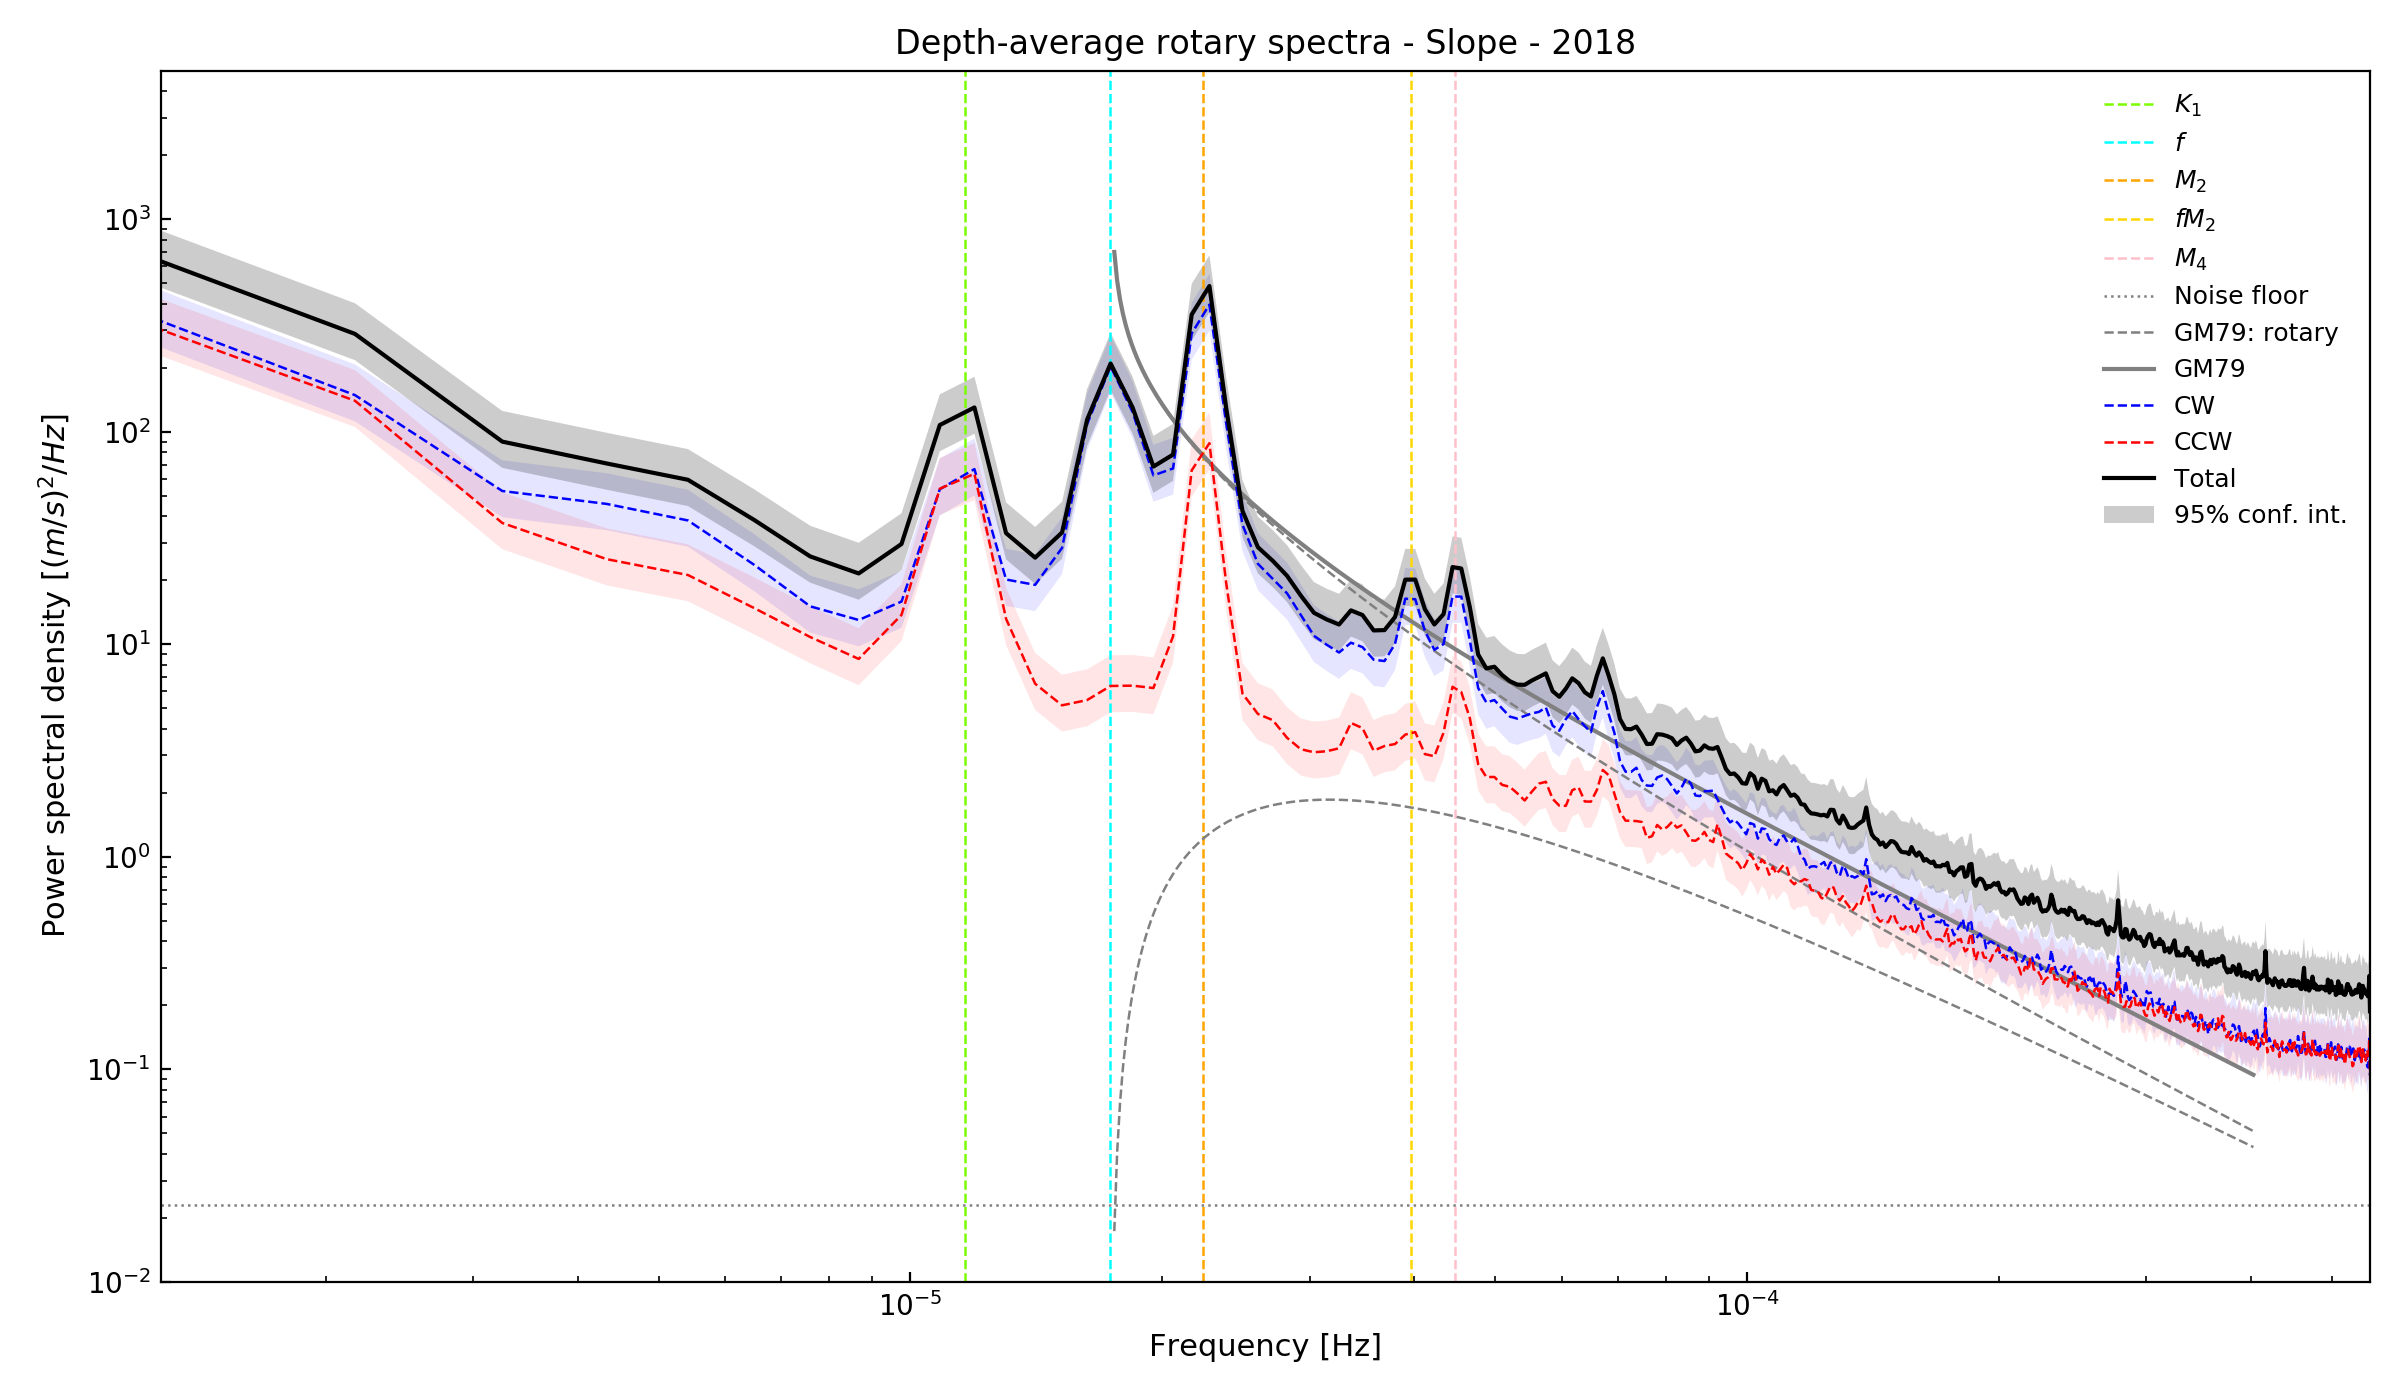

In [65]:
# plot rotary

fig, ax = plt.subplots(1,1,figsize=(12,7))

ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.9,label = "$K_1$") # constituents
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.9,label = "$f$")    
ax.axvline(2.236e-5, color ='orange',ls='--',lw=0.9,label = "$M_2$")
ax.axvline(3.968e-5, color ='gold',ls='--',lw=0.9,label = "$fM_2$")
ax.axvline(4.472e-5, color ='pink',ls='--',lw=0.9,label = "$M_4$")
ax.set_ylim(1e-2,5e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both')
ax.set_title(f'Depth-average rotary spectra - {adcp} - {t_stamp}')
ax.set_ylabel('Power spectral density [$(m/s)^2/Hz$]',fontsize=11)
ax.set_xlabel('Frequency [Hz]',fontsize=11)

if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='grey',ls=':',lw=0.9,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='grey',ls=':',lw=0.9,label='Noise floor')

ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='grey',lw=0.9,ls='--') # rotary GM
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='grey',lw=0.9,ls='--', label='GM79: rotary') # rotary GM
ax.loglog(gm_freq/(2*np.pi),gm_psd*(2*np.pi),color='grey', label='GM79') # GM  

ax.loglog(f, depth_cw, label='CW',color='blue',lw=0.9,ls='--')
ax.loglog(f, depth_ccw, label='CCW',color='red',lw=0.9,ls='--')
ax.loglog(f, (depth_cw + depth_ccw), label='Total',color='black')

ax.fill_between(f, cw_lower, cw_upper, facecolor='blue', alpha=0.1)
ax.fill_between(f, ccw_lower, ccw_upper, facecolor='red', alpha=0.1)
ax.fill_between(f, tot_lower, tot_upper, facecolor='black', alpha=0.2, label = '95% conf. int.')

fig.tight_layout()
plt.legend(loc='upper right',frameon=False,fontsize=9)
plt.show()

plt.savefig(fname=f'./plots/rot_plots/rot_{adcp}_{t_stamp}.pdf',format='pdf')

## Depth comparison rotary (annual)

In [ ]:
# select depths and average

dupidx = 0                                     # upper depth
dlowidx = -1                                   # lower depth
dup_stamp = -depth[dupidx]                     # stamps for plotting
dlow_stamp = -depth[dlowidx]
print('Upper depth:',dup_stamp)
print('Lower depth:',dlow_stamp)

cw_up = avg_cw[dupidx].values / ds[0].WKB_scale[dupidx].values                    # data for plotting, WKB scaled
ccw_up = avg_ccw[dupidx].values / ds[0].WKB_scale[dupidx].values
cw_low = avg_cw[dlowidx].values / ds[0].WKB_scale[dlowidx].values
ccw_low = avg_ccw[dlowidx].values / ds[0].WKB_scale[dlowidx].values

In [ ]:
# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)             # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

cw_low_lower = cw_low * cint[0]             # define upper and lower confidence values
cw_low_upper = cw_low * cint[1]
ccw_low_lower = ccw_low * cint[0]             # define upper and lower confidence values
ccw_low_upper = ccw_low * cint[1]
cw_up_lower = cw_up * cint[0]               # define upper and lower confidence values
cw_up_upper = cw_up * cint[1]
ccw_up_lower = ccw_up * cint[0]               # define upper and lower confidence values
ccw_up_upper = ccw_up * cint[1]

In [ ]:
# plot rotary

fig,ax = plt.subplots(1,1,figsize=(12,7))               # plot CCW and CW components
ax.set_title(f'Rotary spectra - {adcp} - {t_stamp}')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(f'Energy density [$(m/s)^2/Hz$]')
ax.set_ylim(1e-2,5e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 
ax.tick_params(axis='both', direction='in', which='both')

ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") 
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$")    
ax.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$")
ax.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$")
ax.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$")
if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='gray',ls=':',lw=0.8,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='gray',ls=':',lw=0.8,label='Noise floor')
    
ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='gray',lw=0.8, label = 'GM79 - cw') 
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='gray',lw=0.8,ls='--', label = 'GM79 - ccw') 

ax.loglog(f, cw_up, label=f'-{dup_stamp} m - cw',color='blue',lw=1)
ax.loglog(f, ccw_up, label=f'-{dup_stamp} m - ccw',color='blue',ls='--',lw=1)
ax.loglog(f, cw_low, label=f'-{dlow_stamp} m - cw',color='red',lw=1)
ax.loglog(f, ccw_low, label=f'-{dlow_stamp} m - ccw',color='red',ls='--',lw=1)

ax.fill_between(f, cw_up_lower, cw_up_upper, facecolor='blue', alpha=0.1)
ax.fill_between(f, ccw_up_lower, ccw_up_upper, facecolor='blue', alpha=0.1)
ax.fill_between(f, cw_low_lower, cw_low_upper, facecolor='red', alpha=0.1)
ax.fill_between(f, ccw_low_lower, ccw_low_upper, facecolor='red', alpha=0.1, label='95% conf. int.')

fig.tight_layout()
plt.legend(loc='upper right',frameon=False,fontsize=9)
plt.show()

#plt.savefig(fname=f'./plots/rot_plots/rot_comp_{adcp}_{t_stamp}.pdf',format='pdf')